## 构建Fama-French三因子时间序列

***

### 获取S&P 500企业股票信息

Source: https://stackoverflow.com/a/58890872

In [21]:
import bs4 as bs
import requests
import yfinance as yf
import datetime
import pandas as pd

# 爬取企业的tickers
resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})
tickers = []
for row in table.findAll('tr')[1:]:
    ticker = row.findAll('td')[0].text
    tickers.append(ticker)
tickers = [s.replace('\n', '') for s in tickers]

# 输入目标时间段
start = datetime.datetime(2020,4,12)
end = datetime.datetime(2020,7,12)

# 查看数据抓取完整性
data = yf.download(tickers, start=start, end=end)

[*********************100%***********************]  503 of 503 completed

4 Failed downloads:
- OGN: Data doesn't exist for startDate = 1586620800, endDate = 1594483200
- BF.B: No data found for this date range, symbol may be delisted
- BRK.B: No data found, symbol may be delisted
- CEG: Data doesn't exist for startDate = 1586620800, endDate = 1594483200


从结果看出，有四个tickers抓取不到，所以tickers需要更新，去除这四个冗余的。

In [22]:
fail_list = ['CEG', 'OGN','BF.B','BRK.B']
tickers = [t for t in tickers if t not in fail_list]
print('过滤后的ticker数为：',len(tickers))

过滤后的ticker数为： 499


### 获取S&P 500企业的账面市值比

Source: https://medium.com/analytics-vidhya/how-to-calculate-price-book-ratio-with-python-python-for-finance-725286f11e

In [ ]:
# 定义一个抓取BS发布日期的函数
def getdate(stock):
    BS = requests.get(f"https://financialmodelingprep.com/api/v3/financials/balance-sheet-statement/{stock}?period=quarter&apikey=388edbbeae95c0229c3018613d6e0b80")
    BS = BS.json()
    BS_date = str(BS['financials'][8]['date'])
    return(BS_date)

date = getdate('AAPL')
print('BS发布日期为：', date)

In [ ]:
from tqdm import tqdm
import time

def getBM(stock):
    BS = requests.get(f"https://financialmodelingprep.com/api/v3/financials/balance-sheet-statement/{stock}?period=quarter&apikey=388edbbeae95c0229c3018613d6e0b80")
    BS = BS.json()

    book_value_equity_2020Q1 = float(BS['financials'][8]['Total shareholders equity'])  
    
    company_info = requests.get(f"https://financialmodelingprep.com/api/v3/company/profile/{stock}?period=quarter&apikey=388edbbeae95c0229c3018613d6e0b80")
    company_info = company_info.json()
    market_cap =  float(company_info['profile']['mktCap'])
    book_to_market = book_value_equity_2020Q1 / market_cap
    return (book_to_market)
    
BM_list = []
for t in tqdm(tickers):
    try:
        result_t = getBM(t)
    except:
        result_t = 0
    BM_list.append(result_t)
    time.sleep(0.1)
print('抓取成功！')

In [ ]:
# 合并两个lists为一个dataframe
BM_ratio = pd.DataFrame({'Ticker': tickers, 'BM Ratio': BM_list})

# 把ticker设为index
BM_ratio.set_index('Ticker', inplace=True)

# 按照字母顺序排序index
BM_ratio.sort_index(inplace=True)

BM_ratio.head()

In [ ]:
# 看看哪些公司提取不到信息
zero_BM = BM_ratio.loc[BM_ratio['BM Ratio'] == 0]
zero_BM.head()

In [ ]:
# 为这些提取不到信息的tickers创建一个list
zero_list = zero_BM.index.values.tolist()
print(zero_list)

In [ ]:
# 过滤冗余tickers
tickers = [t for t in tickers if t not in zero_list]
print('过滤后的ticker数为：',len(tickers))

In [ ]:
# 筛选出非零的账面市值比
BM_ratio.drop(zero_list, axis=0, inplace=True)
BM_ratio.head()

In [ ]:
# 不想再爬一遍，存起来！
BM_ratio.to_csv('BM Ratio.csv')

### 获取S&P 500企业在2020年4月9日的市值

In [ ]:
start = datetime.datetime(2020,4,10)
end = datetime.datetime(2020,4,12)
data_09042020 = yf.download(tickers, start=start, end=end)
print(data_09042020.head())

In [ ]:
# 提取价格并交换横纵坐标
close_stock = data_09042020['Adj Close']
close_stock.index = ['Adj Close']
close_stock = close_stock.T
close_stock.head()

# 提取交易量并交换横纵坐标
volume_stock = data_09042020['Volume']
volume_stock.index = ['Volume']
volume_stock = volume_stock.T
volume_stock.head()

# 合并上述两者并相乘得出市值
mkt_cap = pd.concat([close_stock, volume_stock], axis=1)
mkt_cap['Mkt Cap'] = mkt_cap['Adj Close'] * mkt_cap['Volume']
mkt_cap.index.names = ['Ticker']
mkt_cap.head()

In [ ]:
mkt_cap.drop(columns=['Adj Close', 'Volume'], inplace = True)
mkt_cap.head()

In [ ]:
mkt_cap.to_csv('Mkt Cap.csv')

### 切分投资组合

以下投资组合划分完全按照Fama和French的研究方法来进行。先按照市值的中位数将公司分为小规模和大规模组。

In [23]:
mkt_cap = pd.read_csv('Mkt Cap.csv')

In [24]:
mkt_cap["Q_MC"] = pd.qcut(mkt_cap["Mkt Cap"], 
                               q=[0, 0.5, 1], 
                               labels=["S", "B"])

mkt_cap = mkt_cap.sort_values("Ticker")

S_MC = mkt_cap.groupby(mkt_cap.Q_MC).get_group("S")
S_MC = S_MC.drop(['Mkt Cap'], axis=1)

B_MC = mkt_cap.groupby(mkt_cap.Q_MC).get_group("B")
B_MC = B_MC.drop(['Mkt Cap'], axis=1)

按照市值中位数大小切分完毕。第二步，再依据公司的账面市值比分别按30%、40%和30%的比例分为三组。

In [25]:
BM_ratio = pd.read_csv('BM Ratio.csv')

In [26]:
BM_ratio["Q_BM"] = pd.qcut(BM_ratio["BM Ratio"], 
                               q=[0, 0.3, 0.7, 1], 
                               labels=["L", "M", "H"])

BM_ratio = BM_ratio.sort_values("Ticker")

L_BM = BM_ratio.groupby(BM_ratio.Q_BM).get_group("L")
L_BM = L_BM.drop(['BM Ratio'], axis=1)

M_BM = BM_ratio.groupby(BM_ratio.Q_BM).get_group("M")
M_BM = M_BM.drop(['BM Ratio'], axis=1)

H_BM = BM_ratio.groupby(BM_ratio.Q_BM).get_group("H")
H_BM = H_BM.drop(['BM Ratio'], axis=1)

交叉得出6组投资组合。

In [27]:
SL = pd.merge(S_MC, L_BM, how='inner', on=['Ticker'])
SM = pd.merge(S_MC, M_BM, how='inner', on=['Ticker'])
SH = pd.merge(S_MC, H_BM, how='inner', on=['Ticker'])
BL = pd.merge(B_MC, L_BM, how='inner', on=['Ticker'])
BM = pd.merge(B_MC, M_BM, how='inner', on=['Ticker'])
BH = pd.merge(B_MC, H_BM, how='inner', on=['Ticker'])

### 投资组合收益的描述性统计

分别计算出六个投资组合SL、SM、SH、BL、BM、BH的平均收益率和标准差。

<mark>SL<mark>

In [28]:
# 抓取SL的tickers的股票信息
SL_list = SL['Ticker'].tolist()
start = datetime.datetime(2020,4,12)
end = datetime.datetime(2020,7,12)
data_SL = yf.download(SL_list, start=start, end=end)

# 获取SL公司报酬率
returns_SL = data_SL['Adj Close'].pct_change()
returns_SL.dropna(inplace = True)

# 求每日报酬率均值
returns_SL['mean_SL'] = returns_SL.mean(axis=1)
avgret_SL = returns_SL[['mean_SL']]
print('SL的平均收益率为：', avgret_SL['mean_SL'].mean())
print('SL的标准差为：', avgret_SL['mean_SL'].std())

[*********************100%***********************]  62 of 62 completed
SL的平均收益率为： 0.0036176407622585793
SL的标准差为： 0.016986956407962626


<mark>SM<mark>

In [29]:
# 抓取SM的tickers的股票信息
SM_list = SM['Ticker'].tolist()
start = datetime.datetime(2020,4,12)
end = datetime.datetime(2020,7,12)
data_SM = yf.download(SM_list, start=start, end=end)

# 获取SM公司报酬率
returns_SM = data_SM['Adj Close'].pct_change()
returns_SM.dropna(inplace = True)

# 求每日报酬率均值
returns_SM['mean_SM'] = returns_SM.mean(axis=1)
avgret_SM = returns_SM[['mean_SM']]
print('SM的平均收益率为：', avgret_SM['mean_SM'].mean())
print('SM的标准差为：', avgret_SM['mean_SM'].std())

[*********************100%***********************]  108 of 108 completed
SM的平均收益率为： 0.0026874431454703123
SM的标准差为： 0.022191273662066992


<mark>SH<mark>

In [30]:
# 抓取SH的tickers的股票信息
SH_list = SH['Ticker'].tolist()
start = datetime.datetime(2020,4,12)
end = datetime.datetime(2020,7,12)
data_SH = yf.download(SH_list, start=start, end=end)

# 获取SH公司报酬率
returns_SH = data_SH['Adj Close'].pct_change()
returns_SH.dropna(inplace = True)

# 求每日报酬率均值
returns_SH['mean_SH'] = returns_SH.mean(axis=1)
avgret_SH = returns_SH[['mean_SH']]
print('SH的平均收益率为：', avgret_SH['mean_SH'].mean())
print('SH的标准差为：', avgret_SH['mean_SH'].std())

[*********************100%***********************]  75 of 75 completed
SH的平均收益率为： 0.001446459496427507
SH的标准差为： 0.02897352754617191


<mark>BL<mark>

In [31]:
# 抓取BL的tickers的股票信息
BL_list = BL['Ticker'].tolist()
start = datetime.datetime(2020,4,12)
end = datetime.datetime(2020,7,12)
data_BL = yf.download(BL_list, start=start, end=end)

# 获取BL公司报酬率
returns_BL = data_BL['Adj Close'].pct_change()
returns_BL.dropna(inplace = True)

# 求每日报酬率均值
returns_BL['mean_BL'] = returns_BL.mean(axis=1)
avgret_BL = returns_BL[['mean_BL']]
print('BL的平均收益率为：', avgret_BL['mean_BL'].mean())
print('BL的标准差为：', avgret_BL['mean_BL'].std())

[*********************100%***********************]  85 of 85 completed
BL的平均收益率为： 0.0034341556619794105
BL的标准差为： 0.017609068902497957


<mark>BM<mark>

In [32]:
# 抓取BM的tickers的股票信息
BM_list = BM['Ticker'].tolist()
start = datetime.datetime(2020,4,12)
end = datetime.datetime(2020,7,12)
data_BM = yf.download(BM_list, start=start, end=end)

# 获取BM公司报酬率
returns_BM = data_BM['Adj Close'].pct_change()
returns_BM.dropna(inplace = True)

# 求每日报酬率均值
returns_BM['mean_BM'] = returns_BM.mean(axis=1)
avgret_BM = returns_BM[['mean_BM']]
print('BM的平均收益率为：', avgret_BM['mean_BM'].mean())
print('BM的标准差为：', avgret_BM['mean_BM'].std())

[*********************100%***********************]  88 of 88 completed
BM的平均收益率为： 0.002597788168375698
BM的标准差为： 0.01906763351508157


<mark>BH<mark>

In [33]:
# 抓取BH的tickers的股票信息
BH_list = BH['Ticker'].tolist()
start = datetime.datetime(2020,4,12)
end = datetime.datetime(2020,7,12)
data_BH = yf.download(BH_list, start=start, end=end)

# 获取BH公司报酬率
returns_BH = data_BH['Adj Close'].pct_change()
returns_BH.dropna(inplace = True)

# 求每日报酬率均值
returns_BH['mean_BH'] = returns_BH.mean(axis=1)
avgret_BH = returns_BH[['mean_BH']]
print('BH的平均收益率为：', avgret_BH['mean_BH'].mean())
print('BH的标准差为：', avgret_BH['mean_BH'].std())

[*********************100%***********************]  72 of 72 completed
BH的平均收益率为： 0.0020682938538895547
BH的标准差为： 0.029358476092995505


### 获取无风险利率

无风险利率取2020年3月31日的一年期T-Bill月度利率，0.32%。此处需要转换为每日利率，如下公式。  
Source：https://ycharts.com/indicators/1_year_treasury_bill_rate_monthly

In [34]:
rf_monthly = 0.0032
rf_daily = (1 + rf_monthly)**(1/30) - 1 
print('无风险利率为：', rf_daily)

无风险利率为： 0.00010650203415640824


### 获取市场指数和每日回报

Source: https://stackoverflow.com/q/71365828

In [35]:
import pandas_datareader.data as web

SP500 = web.DataReader('SP500', 'fred', '2020-04-12', '2020-07-12')

# 计算每日回报率
SP500["Daily Return"] = SP500["SP500"].pct_change()
SP500.dropna(inplace=True)
SP500.rename(columns={"SP500": "S&P 500"}, inplace = True)
SP500.index = SP500.index.rename('Date')
SP500 = SP500.drop('S&P 500', axis=1)
SP500.head()

,Daily Return
Date,
2020-04-14,0.030573
2020-04-15,-0.022030
2020-04-16,0.005817
2020-04-17,0.026794
2020-04-20,-0.017881


### 构建市场因子

市场因子，即用每日指数收益率减去无风险利率。

In [36]:
SP500['mktrf'] = SP500['Daily Return']-rf_daily
mktrf = SP500.drop('Daily Return', axis=1)
mktrf.head()

,mktrf
Date,
2020-04-14,0.030466
2020-04-15,-0.022137
2020-04-16,0.005710
2020-04-17,0.026687
2020-04-20,-0.017987


### 构建公司规模因子SMB

<p>按照以下公式计算：$SMB = {{SL+SM+SH} \over 3}-{{BL+BM+BH} \over 3}$，这些字母表示的是各个投资组合内企业的平均报酬率。<p>
<p>先把大市值和小市值两组公司的tickers导出为两个lists，然后分别从yfinance抓取价格后求收益率，再分别求收益率的均值。<p>

In [37]:
# 将ticker设为index
S_MC.set_index('Ticker', inplace = True)

SMC_list = S_MC.index.values.tolist()
print(SMC_list)

['A', 'AAP', 'ABC', 'ABMD', 'ADM', 'AEE', 'AES', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALK', 'ALLE', 'AMCR', 'AME', 'AMP', 'ANSS', 'AOS', 'APH', 'ARE', 'ATO', 'AVY', 'AWK', 'BBY', 'BEN', 'BIO', 'BKR', 'BR', 'BRO', 'BWA', 'BXP', 'CAG', 'CAH', 'CBOE', 'CBRE', 'CDAY', 'CDNS', 'CDW', 'CE', 'CF', 'CFG', 'CHD', 'CHRW', 'CINF', 'CMA', 'CMI', 'CMS', 'CNP', 'COO', 'CPB', 'CPRT', 'CPT', 'CRL', 'CTAS', 'CTLT', 'CTRA', 'CTVA', 'CZR', 'DFS', 'DGX', 'DISH', 'DLTR', 'DOV', 'DPZ', 'DRE', 'DVA', 'DVN', 'DXC', 'ED', 'EFX', 'EIX', 'EMN', 'EMR', 'EPAM', 'ES', 'ESS', 'ETR', 'EVRG', 'EXPD', 'EXR', 'FAST', 'FBHS', 'FDS', 'FFIV', 'FITB', 'FLT', 'FMC', 'FOX', 'FOXA', 'FRC', 'FRT', 'FTV', 'GL', 'GLW', 'GNRC', 'GPC', 'GRMN', 'GWW', 'HAS', 'HBAN', 'HES', 'HIG', 'HII', 'HOLX', 'HPE', 'HRL', 'HSIC', 'HST', 'HSY', 'HWM', 'IDXX', 'IEX', 'IFF', 'INCY', 'IP', 'IPG', 'IQV', 'IR', 'IRM', 'IT', 'IVZ', 'J', 'JBHT', 'JKHY', 'JNPR', 'K', 'KDP', 'KEY', 'KEYS', 'KIM', 'KLAC', 'KMX', 'L', 'LDOS', 'LKQ', 'LNC', 'LNT', 'LW', 'LYB', 'MAA'

In [38]:
# 将ticker设为index
B_MC.set_index('Ticker', inplace = True)

BMC_list = B_MC.index.values.tolist()
print(BMC_list)

['AAL', 'AAPL', 'ABBV', 'ABT', 'ACN', 'ADBE', 'ADI', 'ADP', 'ADSK', 'AEP', 'AFL', 'AIG', 'ALGN', 'ALL', 'AMAT', 'AMD', 'AMT', 'AMZN', 'ANET', 'AON', 'APA', 'APD', 'APTV', 'ATVI', 'AVB', 'AVGO', 'AXP', 'AZO', 'BA', 'BAC', 'BAX', 'BDX', 'BIIB', 'BK', 'BKNG', 'BLK', 'BMY', 'BSX', 'C', 'CARR', 'CAT', 'CB', 'CCI', 'CCL', 'CHTR', 'CI', 'CL', 'CLX', 'CMCSA', 'CME', 'CMG', 'CNC', 'COF', 'COP', 'COST', 'CRM', 'CSCO', 'CSX', 'CTSH', 'CTXS', 'CVS', 'CVX', 'D', 'DAL', 'DD', 'DE', 'DG', 'DHI', 'DHR', 'DIS', 'DLR', 'DOW', 'DRI', 'DTE', 'DUK', 'DXCM', 'EA', 'EBAY', 'ECL', 'EL', 'ENPH', 'EOG', 'EQIX', 'EQR', 'ETN', 'ETSY', 'EW', 'EXC', 'EXPE', 'F', 'FANG', 'FCX', 'FDX', 'FE', 'FIS', 'FISV', 'FTNT', 'GD', 'GE', 'GILD', 'GIS', 'GM', 'GOOG', 'GOOGL', 'GPN', 'GS', 'HAL', 'HCA', 'HD', 'HLT', 'HON', 'HPQ', 'HUM', 'IBM', 'ICE', 'ILMN', 'INTC', 'INTU', 'ISRG', 'ITW', 'JCI', 'JNJ', 'JPM', 'KHC', 'KMB', 'KMI', 'KO', 'KR', 'LEN', 'LH', 'LHX', 'LIN', 'LLY', 'LMT', 'LOW', 'LRCX', 'LUV', 'LVS', 'LYV', 'MA', 'MAR', 

In [39]:
# 抓取小市值企业股票信息
start = datetime.datetime(2020,4,12)
end = datetime.datetime(2020,7,12)
data_SMC = yf.download(SMC_list, start=start, end=end)
print(data_SMC.head())

[*********************100%***********************]  245 of 245 completed
            Adj Close                                                \
                    A         AAP        ABC        ABMD        ADM   
Date                                                                  
2020-04-13  75.130135  107.590042  82.784035  156.389999  34.151207   
2020-04-14  77.713020  112.861938  86.630165  161.350006  35.258965   
2020-04-15  75.958244  109.536438  85.574181  159.539993  33.602062   
2020-04-16  77.634155  114.955048  83.588135  160.199997  33.763016   
2020-04-17  78.422813  116.255928  86.407349  166.020004  35.211628   

                                                                     ...  \
                  AEE        AES         AIZ        AJG        AKAM  ...   
Date                                                                 ...   
2020-04-13  71.488953  13.388396  104.515358  81.148338   95.190002  ...   
2020-04-14  72.761833  13.218567  103.668228  84.03227

In [40]:
# 抓取大市值企业股票信息
start = datetime.datetime(2020,4,12)
end = datetime.datetime(2020,7,12)
data_BMC = yf.download(BMC_list, start=start, end=end)
print(data_BMC.head())

[*********************100%***********************]  245 of 245 completed
           Adj Close                                                           \
                 AAL       AAPL       ABBV        ABT         ACN        ADBE   
Date                                                                            
2020-04-13     11.56  67.672096  72.830475  83.290741  167.982834  320.649994   
2020-04-14     11.95  71.089745  75.601181  86.846832  173.365845  340.769989   
2020-04-15     12.29  70.440895  75.315842  88.600533  165.690033  332.549988   
2020-04-16     11.07  71.000603  75.352654  93.530357  164.223312  342.700012   
2020-04-17     11.57  70.037216  76.816254  93.540100  171.204895  344.109985   

                                                          ...    Volume  \
                  ADI         ADP        ADSK        AEP  ...       WFC   
Date                                                      ...             
2020-04-13  95.203865  135.719498  160.919998  76.698

Source: https://www.codingfinance.com/post/2018-04-03-calc-returns-py/

In [41]:
# 获取小市值公司报酬率
returns_SMC = data_SMC['Adj Close'].pct_change()
returns_SMC.dropna(inplace = True)

# 求每日报酬率均值
returns_SMC['Mean_SMC'] = returns_SMC.mean(axis=1)
avgret_SMC = returns_SMC[['Mean_SMC']]
avgret_SMC.head()

,Mean_SMC
Date,
2020-04-14,0.022390
2020-04-15,-0.038329
2020-04-16,-0.005444
2020-04-17,0.043324
2020-04-20,-0.020909


In [42]:
# 获取大市值公司报酬率
returns_BMC = data_BMC['Adj Close'].pct_change()
returns_BMC.dropna(inplace = True)

# 求每日报酬率均值
returns_BMC['Mean_BMC'] = returns_BMC.mean(axis=1)
avgret_BMC = returns_BMC[['Mean_BMC']]
avgret_BMC.head()

,Mean_BMC
Date,
2020-04-14,0.028270
2020-04-15,-0.028406
2020-04-16,-0.003942
2020-04-17,0.042244
2020-04-20,-0.021489


In [43]:
# 计算出smb的时间序列
smb = pd.concat([avgret_SMC, avgret_BMC], axis=1)
smb['smb'] = (smb['Mean_SMC']/3)-(smb['Mean_BMC']/3)
smb = smb[['smb']]
smb.head()

,smb
Date,
2020-04-14,-0.001960
2020-04-15,-0.003307
2020-04-16,-0.000500
2020-04-17,0.000360
2020-04-20,0.000193


### 构建公司价值因子HML

<p>按照以下公式计算：$HML = {{SH+BH} \over 2}-{{SL+BL} \over 2}$<p>
<p>先把高PB和低PB两组公司的tickers导出为两个lists，然后分别从yfinance抓取价格后求收益率，再分别求收益率的均值。<p>

In [44]:
# 整合高PB的tickers
HBM_list = H_BM['Ticker'].tolist()
len(HBM_list)

147

In [45]:
# 整合低PB的tickers
LBM_list = L_BM['Ticker'].tolist()
len(LBM_list)

147

In [46]:
# 抓取高PB的tickers的股票信息
start = datetime.datetime(2020,4,12)
end = datetime.datetime(2020,7,12)
data_HBM = yf.download(HBM_list, start=start, end=end)
print(data_HBM.head())

[*********************100%***********************]  147 of 147 completed
            Adj Close                                                          \
                  ADM        AEP        AFL        AIG         AIZ        ALK   
Date                                                                            
2020-04-13  34.151207  77.910782  34.886379  24.283768  104.515358  29.510000   
2020-04-14  35.258965  80.476700  35.354282  24.425890  103.668228  31.049999   
2020-04-15  33.602062  78.013420  33.454620  22.815180   97.622757  30.080000   
2020-04-16  33.763016  78.423973  32.790211  21.962458   96.823753  28.260000   
2020-04-17  35.211628  80.597984  34.137753  23.213121  101.858429  29.930000   

                                                           ...   Volume  \
                  ALL         ARE         ATO         AVB  ...      WAB   
Date                                                       ...            
2020-04-13  93.235428  141.150543   98.143585  151.88

In [47]:
# 抓取低PB的tickers的股票信息
start = datetime.datetime(2020,4,12)
end = datetime.datetime(2020,7,12)
data_LBM = yf.download(LBM_list, start=start, end=end)
print(data_LBM.head())

[*********************100%***********************]  147 of 147 completed
           Adj Close                                                           \
                 AAL       AAPL       ABBV        ABC        ABMD         ACN   
Date                                                                            
2020-04-13     11.56  67.672096  72.830475  82.784035  156.389999  167.982834   
2020-04-14     11.95  71.089745  75.601181  86.630165  161.350006  173.365845   
2020-04-15     12.29  70.440895  75.315842  85.574181  159.539993  165.690033   
2020-04-16     11.07  71.000603  75.352654  83.588135  160.199997  164.223312   
2020-04-17     11.57  70.037216  76.816254  86.407349  166.020004  171.204895   

                                                           ...    Volume  \
                  ADBE         ADP        ADSK       ALLE  ...         V   
Date                                                       ...             
2020-04-13  320.649994  135.719498  160.919998  93

In [48]:
# 获取低PB公司报酬率
returns_LBM = data_LBM['Adj Close'].pct_change()
returns_LBM.dropna(inplace = True)

# 求每日报酬率均值
returns_LBM['Mean_LBM'] = returns_LBM.mean(axis=1)
avgret_LBM = returns_LBM[['Mean_LBM']]
avgret_LBM.head()

,Mean_LBM
Date,
2020-04-14,0.035746
2020-04-15,-0.020313
2020-04-16,0.007823
2020-04-17,0.029957
2020-04-20,-0.015928


In [49]:
# 获取高PB公司报酬率
returns_HBM = data_HBM['Adj Close'].pct_change()
returns_HBM.dropna(inplace = True)
returns_HBM.head()

,ADM,AEP,AFL,AIG,AIZ,ALK,ALL,ARE,ATO,AVB,...,WAB,WBA,WDC,WELL,WFC,WRK,XOM,XRAY,ZBH,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2020-04-14,0.032437,0.032934,0.013412,0.005853,-0.008105,0.052186,0.045306,0.054360,0.046867,0.034818,...,0.011964,0.051462,0.023080,0.016578,-0.039771,-0.016338,-0.007717,0.012923,0.051565,-0.017952
2020-04-15,-0.046992,-0.030609,-0.053732,-0.065943,-0.058316,-0.031240,-0.043928,-0.021563,-0.016280,-0.035622,...,-0.053394,-0.063389,-0.047353,-0.090347,-0.057654,-0.050141,-0.045958,-0.019872,-0.030548,-0.051794
2020-04-16,0.004790,0.005263,-0.019860,-0.037375,-0.008185,-0.060505,0.020319,0.000395,-0.011848,0.001056,...,-0.042708,-0.004834,-0.036811,-0.026582,-0.054501,-0.049159,-0.032856,-0.021777,-0.007265,-0.038201
2020-04-17,0.042905,0.027721,0.041096,0.056946,0.051998,0.059094,0.049935,0.021306,0.053383,0.056558,...,0.036406,0.029378,0.030185,0.039373,0.055411,0.064886,0.103959,0.045548,0.084705,0.079436
2020-04-20,-0.022856,-0.040171,-0.009046,-0.030612,-0.026368,-0.023388,-0.020968,-0.027815,-0.073803,-0.057874,...,-0.006091,-0.037079,-0.065454,-0.075764,-0.024665,-0.033561,-0.047200,0.010279,-0.013324,0.006534


In [50]:
# 求每日报酬率均值
returns_HBM['Mean_HBM'] = returns_HBM.mean(axis=1)
avgret_HBM = returns_HBM[['Mean_HBM']]
avgret_HBM.head()

,Mean_HBM
Date,
2020-04-14,0.016403
2020-04-15,-0.046134
2020-04-16,-0.019306
2020-04-17,0.054836
2020-04-20,-0.026214


In [51]:
# 计算出hml的时间序列
hml = pd.concat([avgret_HBM, avgret_LBM], axis=1)
hml['hml'] = (hml['Mean_HBM']/2)-(hml['Mean_LBM']/2)
hml = hml[['hml']]
hml.head()

,hml
Date,
2020-04-14,-0.009671
2020-04-15,-0.012910
2020-04-16,-0.013565
2020-04-17,0.012440
2020-04-20,-0.005143


### 读取因子数据

In [52]:
FF3 = pd.concat((mktrf, smb, hml), axis=1)
#FF3['date'] = pd.to_datetime(FF3['date'], format="%Y/%m/%d")
#FF3 = FF3.set_index('Date')
FF3.dropna()
FF3.head()

,mktrf,smb,hml
Date,,,
2020-04-14,0.030466,-0.001960,-0.009671
2020-04-15,-0.022137,-0.003307,-0.012910
2020-04-16,0.005710,-0.000500,-0.013565
2020-04-17,0.026687,0.000360,0.012440
2020-04-20,-0.017987,0.000193,-0.005143


### 平稳性检验

在进行回归分析之前，本文对各个变量进行了单位根检验。这是由于当解释变量存在单位根时，该时间序列不是静止的，做回归分析时会使变量间存在虚假关系，即出现伪回归现象。

Source: https://machinelearningmastery.com/time-series-data-stationary-python/

<mark>SL的ADF检验结果<mark>

In [53]:
from statsmodels.tsa.stattools import adfuller

X_SL = returns_SL['mean_SL'].values
SL_adf = adfuller(X_SL)
print('ADF Statistic: %f' % SL_adf[0])
print('p-value: %f' % SL_adf[1])
print('Critical Values:')
for key, value in SL_adf[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.354837
p-value: 0.000004
Critical Values:
	1%: -3.548
	5%: -2.913
	10%: -2.594


<mark>SM的ADF检验结果<mark>

In [54]:
X_SM = returns_SM['mean_SM'].values
SM_adf = adfuller(X_SM)
print('ADF Statistic: %f' % SM_adf[0])
print('p-value: %f' % SM_adf[1])
print('Critical Values:')
for key, value in SM_adf[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.207538
p-value: 0.000008
Critical Values:
	1%: -3.546
	5%: -2.912
	10%: -2.594


<mark>SH的ADF检验结果<mark>

In [55]:
X_SH = returns_SH['mean_SH'].values
SH_adf = adfuller(X_SH)
print('ADF Statistic: %f' % SH_adf[0])
print('p-value: %f' % SH_adf[1])
print('Critical Values:')
for key, value in SH_adf[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.338151
p-value: 0.000005
Critical Values:
	1%: -3.546
	5%: -2.912
	10%: -2.594


<mark>BL的ADF检验结果<mark>

In [56]:
X_BL = returns_BL['mean_BL'].values
BL_adf = adfuller(X_BL)
print('ADF Statistic: %f' % BL_adf[0])
print('p-value: %f' % BL_adf[1])
print('Critical Values:')
for key, value in BL_adf[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.725969
p-value: 0.000001
Critical Values:
	1%: -3.548
	5%: -2.913
	10%: -2.594


<mark>BM的ADF检验结果<mark>

In [57]:
X_BM = returns_BM['mean_BM'].values
BM_adf = adfuller(X_BM)
print('ADF Statistic: %f' % BM_adf[0])
print('p-value: %f' % BM_adf[1])
print('Critical Values:')
for key, value in BM_adf[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.197059
p-value: 0.000009
Critical Values:
	1%: -3.548
	5%: -2.913
	10%: -2.594


<mark>BH的ADF检验结果<mark>

In [58]:
X_BH = returns_BH['mean_BH'].values
BH_adf = adfuller(X_BH)
print('ADF Statistic: %f' % BH_adf[0])
print('p-value: %f' % BH_adf[1])
print('Critical Values:')
for key, value in BH_adf[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.377603
p-value: 0.000004
Critical Values:
	1%: -3.546
	5%: -2.912
	10%: -2.594


<mark>MKTRF的ADF检验结果<mark>

In [59]:
X_MKTRF = FF3['mktrf'].values
MKTRF_adf = adfuller(X_MKTRF)
print('ADF Statistic: %f' % MKTRF_adf[0])
print('p-value: %f' % MKTRF_adf[1])
print('Critical Values:')
for key, value in MKTRF_adf[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.490130
p-value: 0.000002
Critical Values:
	1%: -3.548
	5%: -2.913
	10%: -2.594


<mark>SMB的ADF检验结果<mark>

In [60]:
X_SMB = FF3['smb'].values
SMB_adf = adfuller(X_SMB)
print('ADF Statistic: %f' % SMB_adf[0])
print('p-value: %f' % SMB_adf[1])
print('Critical Values:')
for key, value in SMB_adf[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.582607
p-value: 0.000000
Critical Values:
	1%: -3.542
	5%: -2.910
	10%: -2.593


<mark>HML的ADF检验结果<mark>

In [61]:
X_HML = FF3['hml'].values
HML_adf = adfuller(X_HML)
print('ADF Statistic: %f' % HML_adf[0])
print('p-value: %f' % HML_adf[1])
print('Critical Values:')
for key, value in HML_adf[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.825442
p-value: 0.000000
Critical Values:
	1%: -3.542
	5%: -2.910
	10%: -2.593


### 相关性检验

在进行回归分析之前，需要进行各个解释变量之间的相关关系检验。因为如果解释变量之间存在很强的相关关系，在进行回归分析时，可能会出现共线性的问题，影响最终的回归结果。

In [62]:
# FF3 = FF3.drop(['rf'], axis=1)
FF3.corr()

,mktrf,smb,hml
mktrf,1.000000,0.069396,0.496578
smb,0.069396,1.000000,0.528775
hml,0.496578,0.528775,1.000000


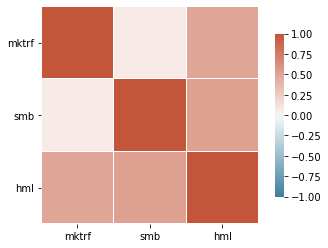

In [136]:
import seaborn as sns
import matplotlib.pyplot as plt
# Define a nice color map for our heatmap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(
        data=FF3.corr(),  # our correlation matrix
        linewidths=0.3,  # the width of lines separating the matrix squares
        square=True,   # enforce 1:1 ratios among correlation cells
        cmap=cmap,  # use the color map we defined above
        vmax=1,  # define the max of our correlation scale
        vmin=-1, # define the min of our correlation scale
        center=0,  # The value at which the color map is centered about (white)
        cbar_kws={"shrink": .75}  # shrink the scale a bit
    )
# adjust y-axis ticks for legibility
plt.yticks(rotation=0)  
# show the heatmap
plt.show()

In [137]:
%store -r tweets_senti

In [139]:
X_senti = tweets_senti['senti score'].values
senti_adf = adfuller(X_senti)
print('ADF Statistic: %f' % senti_adf[0])
print('p-value: %f' % senti_adf[1])
print('Critical Values:')
for key, value in senti_adf[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.117156
p-value: 0.000013
Critical Values:
	1%: -3.519
	5%: -2.900
	10%: -2.587


In [64]:
# Initial setup
# tweets_senti= tweets_senti.set_index('date')
FF3_senti = pd.concat([FF3, tweets_senti], axis=1)
FF3_senti = FF3_senti.dropna()
FF3_senti.corr()

,mktrf,smb,hml,senti score
mktrf,1.000000,-0.123491,0.418544,0.376565
smb,-0.123491,1.000000,0.382786,-0.232257
hml,0.418544,0.382786,1.000000,0.117630
senti score,0.376565,-0.232257,0.117630,1.000000


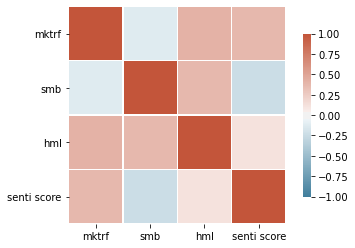

In [146]:
import seaborn as sns
import matplotlib.pyplot as plt
# Define a nice color map for our heatmap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(
        data=FF3_senti.corr(),  # our correlation matrix
        linewidths=0.3,  # the width of lines separating the matrix squares
        square=True,   # enforce 1:1 ratios among correlation cells
        cmap=cmap,  # use the color map we defined above
        vmax=1,  # define the max of our correlation scale
        vmin=-1, # define the min of our correlation scale
        center=0,  # The value at which the color map is centered about (white)
        cbar_kws={"shrink": .75}  # shrink the scale a bit
    )
# adjust y-axis ticks for legibility
plt.yticks(rotation=0)  
# show the heatmap
plt.show()

# 回归分析

### CAPM

In [100]:
import statsmodels.api as sm

In [101]:
CAPM = FF3[['mktrf']]
CAPM.head()

,mktrf
Date,
2020-04-14,0.030466
2020-04-15,-0.022137
2020-04-16,0.005710
2020-04-17,0.026687
2020-04-20,-0.017987


In [102]:
# Initial setup
CAPM_ret = pd.concat([CAPM, 
                      avgret_SL-rf_daily, 
                      avgret_SM-rf_daily, 
                      avgret_SH-rf_daily, 
                      avgret_BL-rf_daily, 
                      avgret_BM-rf_daily, 
                      avgret_BH-rf_daily], axis=1)
CAPM_ret = CAPM_ret.dropna()
CAPM_ret.head()

,mktrf,mean_SL,mean_SM,mean_SH,mean_BL,mean_BM,mean_BH
Date,,,,,,,
2020-04-14,0.030466,0.032104,0.022628,0.013670,0.038218,0.025923,0.019033
2020-04-15,-0.022137,-0.022005,-0.039226,-0.050879,-0.019263,-0.026897,-0.041408
2020-04-16,0.005710,0.012178,-0.005699,-0.019992,0.004462,-0.000193,-0.018810
2020-04-17,0.026687,0.027919,0.045479,0.052608,0.031259,0.040536,0.056939
2020-04-20,-0.017987,-0.014134,-0.023265,-0.023464,-0.017420,-0.019327,-0.029296


In [103]:
X = CAPM_ret[['mktrf']]
y = CAPM_ret['mean_SL']
X = sm.add_constant(X)
CAPM_model = sm.OLS(y, X).fit()
print(CAPM_model.summary())
intercept, b1 = CAPM_model.params

                            OLS Regression Results                            
Dep. Variable:                mean_SL   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     746.6
Date:                Sat, 03 Sep 2022   Prob (F-statistic):           1.49e-35
Time:                        11:45:28   Log-Likelihood:                 245.75
No. Observations:                  62   AIC:                            -487.5
Df Residuals:                      60   BIC:                            -483.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.001      2.016      0.0

In [104]:
X = CAPM_ret[['mktrf']]
y = CAPM_ret['mean_SM']
X = sm.add_constant(X)
CAPM_model = sm.OLS(y, X).fit()
print(CAPM_model.summary())
intercept, b1 = CAPM_model.params

                            OLS Regression Results                            
Dep. Variable:                mean_SM   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     304.2
Date:                Sat, 03 Sep 2022   Prob (F-statistic):           3.57e-25
Time:                        11:45:29   Log-Likelihood:                 204.54
No. Observations:                  62   AIC:                            -405.1
Df Residuals:                      60   BIC:                            -400.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.001     -0.238      0.8

In [105]:
X = CAPM_ret[['mktrf']]
y = CAPM_ret['mean_SH']
X = sm.add_constant(X)
CAPM_model = sm.OLS(y, X).fit()
print(CAPM_model.summary())
intercept, b1 = CAPM_model.params

                            OLS Regression Results                            
Dep. Variable:                mean_SH   R-squared:                       0.727
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     159.5
Date:                Sat, 03 Sep 2022   Prob (F-statistic):           1.50e-18
Time:                        11:45:29   Log-Likelihood:                 172.31
No. Observations:                  62   AIC:                            -340.6
Df Residuals:                      60   BIC:                            -336.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0021      0.002     -1.093      0.2

In [106]:
X = CAPM_ret[['mktrf']]
y = CAPM_ret['mean_BL']
X = sm.add_constant(X)
CAPM_model = sm.OLS(y, X).fit()
print(CAPM_model.summary())
intercept, b1 = CAPM_model.params

                            OLS Regression Results                            
Dep. Variable:                mean_BL   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     2834.
Date:                Sat, 03 Sep 2022   Prob (F-statistic):           3.29e-52
Time:                        11:45:30   Log-Likelihood:                 283.12
No. Observations:                  62   AIC:                            -562.2
Df Residuals:                      60   BIC:                            -558.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      2.659      0.0

In [107]:
X = CAPM_ret[['mktrf']]
y = CAPM_ret['mean_BM']
X = sm.add_constant(X)
CAPM_model = sm.OLS(y, X).fit()
print(CAPM_model.summary())
intercept, b1 = CAPM_model.params

                            OLS Regression Results                            
Dep. Variable:                mean_BM   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     1174.
Date:                Sat, 03 Sep 2022   Prob (F-statistic):           4.24e-41
Time:                        11:45:30   Log-Likelihood:                 251.77
No. Observations:                  62   AIC:                            -499.5
Df Residuals:                      60   BIC:                            -495.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001      0.001     -0.238      0.8

In [108]:
X = CAPM_ret[['mktrf']]
y = CAPM_ret['mean_BH']
X = sm.add_constant(X)
CAPM_model = sm.OLS(y, X).fit()
print(CAPM_model.summary())
intercept, b1 = CAPM_model.params

                            OLS Regression Results                            
Dep. Variable:                mean_BH   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     212.0
Date:                Sat, 03 Sep 2022   Prob (F-statistic):           2.36e-21
Time:                        11:45:31   Log-Likelihood:                 178.13
No. Observations:                  62   AIC:                            -352.3
Df Residuals:                      60   BIC:                            -348.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0017      0.002     -0.948      0.3

### CAPM_Senti

In [140]:
%store -r tweets_senti

In [141]:
# tweets_senti = tweets_senti.set_index('date')
tweets_senti.head()

,senti score
date,
2020-04-09,0.357220
2020-04-10,0.356228
2020-04-11,0.453090
2020-04-12,0.409756
2020-04-13,0.434693


In [144]:
CAPM_senti = pd.concat([CAPM, tweets_senti], axis=1)
CAPM_senti = CAPM_senti.dropna()
CAPM_senti.head()

,mktrf,senti score
2020-04-14,0.030466,0.450438
2020-04-15,-0.022137,0.412081
2020-04-16,0.005710,0.434884
2020-04-17,0.026687,0.419058
2020-04-20,-0.017987,0.352074


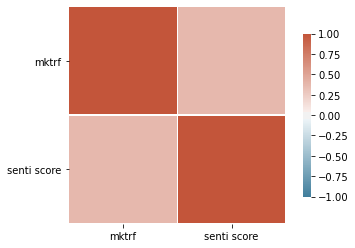

In [145]:
import seaborn as sns
import matplotlib.pyplot as plt
# Define a nice color map for our heatmap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(
        data=CAPM_senti.corr(),  # our correlation matrix
        linewidths=0.3,  # the width of lines separating the matrix squares
        square=True,   # enforce 1:1 ratios among correlation cells
        cmap=cmap,  # use the color map we defined above
        vmax=1,  # define the max of our correlation scale
        vmin=-1, # define the min of our correlation scale
        center=0,  # The value at which the color map is centered about (white)
        cbar_kws={"shrink": .75}  # shrink the scale a bit
    )
# adjust y-axis ticks for legibility
plt.yticks(rotation=0)  
# show the heatmap
plt.show()

In [111]:
# Initial setup
CAPM_senti_ret = pd.concat([CAPM, tweets_senti, avgret_SL, avgret_SM, avgret_SH, avgret_BL, avgret_BM, avgret_BH], axis=1)
CAPM_senti_ret = CAPM_senti_ret.dropna()
CAPM_senti_ret.head()

,mktrf,senti score,mean_SL,mean_SM,mean_SH,mean_BL,mean_BM,mean_BH
2020-04-14,0.030466,0.450438,0.032211,0.022734,0.013777,0.038324,0.026030,0.019139
2020-04-15,-0.022137,0.412081,-0.021899,-0.039120,-0.050773,-0.019157,-0.026791,-0.041301
2020-04-16,0.005710,0.434884,0.012285,-0.005593,-0.019885,0.004569,-0.000086,-0.018704
2020-04-17,0.026687,0.419058,0.028025,0.045585,0.052714,0.031365,0.040643,0.057045
2020-04-20,-0.017987,0.352074,-0.014028,-0.023158,-0.023357,-0.017314,-0.019220,-0.029190


In [151]:
from statsmodels.tsa.stattools import grangercausalitytests
grangercausalitytests(CAPM_senti_ret[['mean_SL', 'mktrf']], maxlag=2)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6564  , p=0.2050  , df_denom=43, df_num=1
ssr based chi2 test:   chi2=1.7719  , p=0.1831  , df=1
likelihood ratio test: chi2=1.7386  , p=0.1873  , df=1
parameter F test:         F=1.6564  , p=0.2050  , df_denom=43, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.1994  , p=0.0098  , df_denom=40, df_num=2
ssr based chi2 test:   chi2=11.6987 , p=0.0029  , df=2
likelihood ratio test: chi2=10.3990 , p=0.0055  , df=2
parameter F test:         F=5.1994  , p=0.0098  , df_denom=40, df_num=2


{1: ({'ssr_ftest': (1.6563604315107672, 0.2049806144372506, 43.0, 1),
   'ssr_chi2test': (1.7719204616161695, 0.18314458527080973, 1),
   'lrtest': (1.7386450884443434, 0.18731059459306168, 1),
   'params_ftest': (1.6563604315107607, 0.2049806144372541, 43.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (5.199417148083661, 0.009835354008432839, 40.0, 2),
   'ssr_chi2test': (11.698688583188238, 0.0028817881514210126, 2),
   'lrtest': (10.39898662432222, 0.005519360305125715, 2),
   'params_ftest': (5.199417148083655, 0.009835354008432894, 40.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])])}

In [149]:
from statsmodels.tsa.stattools import grangercausalitytests
grangercausalitytests(CAPM_senti_ret[['mean_SM', 'senti score']], maxlag=2)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0620  , p=0.1582  , df_denom=43, df_num=1
ssr based chi2 test:   chi2=2.2059  , p=0.1375  , df=1
likelihood ratio test: chi2=2.1546  , p=0.1421  , df=1
parameter F test:         F=2.0620  , p=0.1582  , df_denom=43, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5055  , p=0.2342  , df_denom=40, df_num=2
ssr based chi2 test:   chi2=3.3874  , p=0.1838  , df=2
likelihood ratio test: chi2=3.2659  , p=0.1954  , df=2
parameter F test:         F=1.5055  , p=0.2342  , df_denom=40, df_num=2


{1: ({'ssr_ftest': (2.0620354949585438, 0.15824380554292103, 43.0, 1),
   'ssr_chi2test': (2.2058984364672796, 0.13748377376933693, 1),
   'lrtest': (2.154639598922074, 0.14213979195116877, 1),
   'params_ftest': (2.062035494958543, 0.15824380554292103, 43.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (1.5054904991051035, 0.23421400727349653, 40.0, 2),
   'ssr_chi2test': (3.387353622986483, 0.18384232621364988, 2),
   'lrtest': (3.2659200463110096, 0.1953504755460755, 2),
   'params_ftest': (1.5054904991051083, 0.23421400727349542, 40.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])])}

In [150]:
from statsmodels.tsa.stattools import grangercausalitytests
grangercausalitytests(CAPM_senti_ret[['mean_SH', 'senti score']], maxlag=2)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0727  , p=0.1572  , df_denom=43, df_num=1
ssr based chi2 test:   chi2=2.2173  , p=0.1365  , df=1
likelihood ratio test: chi2=2.1656  , p=0.1411  , df=1
parameter F test:         F=2.0727  , p=0.1572  , df_denom=43, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2422  , p=0.2996  , df_denom=40, df_num=2
ssr based chi2 test:   chi2=2.7950  , p=0.2472  , df=2
likelihood ratio test: chi2=2.7117  , p=0.2577  , df=2
parameter F test:         F=1.2422  , p=0.2996  , df_denom=40, df_num=2


{1: ({'ssr_ftest': (2.072727885616631, 0.1571940552627022, 43.0, 1),
   'ssr_chi2test': (2.2173368078689544, 0.1364682874795096, 1),
   'lrtest': (2.1655532565195017, 0.14113381918087178, 1),
   'params_ftest': (2.0727278856166316, 0.1571940552627022, 43.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (1.2422401423402096, 0.2996357504854991, 40.0, 2),
   'ssr_chi2test': (2.7950403202654717, 0.24720924378814854, 2),
   'lrtest': (2.711672340907114, 0.25773169669642837, 2),
   'params_ftest': (1.2422401423402116, 0.29963575048549773, 40.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])])}

In [154]:
X = CAPM_senti_ret[['mktrf', 'senti score']]
y = CAPM_senti_ret['mean_SL']
X = sm.add_constant(X)
CAPM_Senti_model = sm.OLS(y, X).fit()
print(CAPM_Senti_model.summary())
intercept, b1, b2 = CAPM_Senti_model.params

                            OLS Regression Results                            
Dep. Variable:                mean_SL   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     280.6
Date:                Sun, 04 Sep 2022   Prob (F-statistic):           9.02e-26
Time:                        20:30:09   Log-Likelihood:                 187.41
No. Observations:                  47   AIC:                            -368.8
Df Residuals:                      44   BIC:                            -363.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0215      0.008      2.727      

In [155]:
X = CAPM_senti_ret[['mktrf', 'senti score']]
y = CAPM_senti_ret['mean_SM']
X = sm.add_constant(X)
CAPM_Senti_model = sm.OLS(y, X).fit()
print(CAPM_Senti_model.summary())
intercept, b1, b2 = CAPM_Senti_model.params

                            OLS Regression Results                            
Dep. Variable:                mean_SM   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     118.7
Date:                Sun, 04 Sep 2022   Prob (F-statistic):           1.86e-18
Time:                        20:30:24   Log-Likelihood:                 159.49
No. Observations:                  47   AIC:                            -313.0
Df Residuals:                      44   BIC:                            -307.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0252      0.014      1.768      

In [114]:
X = CAPM_senti_ret[['mktrf', 'senti score']]
y = CAPM_senti_ret['mean_SH']
X = sm.add_constant(X)
CAPM_Senti_model = sm.OLS(y, X).fit()
print(CAPM_Senti_model.summary())
intercept, b1, b2 = CAPM_Senti_model.params

                            OLS Regression Results                            
Dep. Variable:                mean_SH   R-squared:                       0.712
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     54.32
Date:                Sat, 03 Sep 2022   Prob (F-statistic):           1.30e-12
Time:                        11:46:09   Log-Likelihood:                 132.70
No. Observations:                  47   AIC:                            -259.4
Df Residuals:                      44   BIC:                            -253.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0179      0.025      0.710      

In [115]:
X = CAPM_senti_ret[['mktrf', 'senti score']]
y = CAPM_senti_ret['mean_BL']
X = sm.add_constant(X)
CAPM_Senti_model = sm.OLS(y, X).fit()
print(CAPM_Senti_model.summary())
intercept, b1, b2 = CAPM_Senti_model.params

                            OLS Regression Results                            
Dep. Variable:                mean_BL   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     1163.
Date:                Sat, 03 Sep 2022   Prob (F-statistic):           8.13e-39
Time:                        11:46:10   Log-Likelihood:                 216.90
No. Observations:                  47   AIC:                            -427.8
Df Residuals:                      44   BIC:                            -422.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0063      0.004      1.510      

In [116]:
X = CAPM_senti_ret[['mktrf', 'senti score']]
y = CAPM_senti_ret['mean_BM']
X = sm.add_constant(X)
CAPM_Senti_model = sm.OLS(y, X).fit()
print(CAPM_Senti_model.summary())
intercept, b1, b2 = CAPM_Senti_model.params

                            OLS Regression Results                            
Dep. Variable:                mean_BM   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     484.1
Date:                Sat, 03 Sep 2022   Prob (F-statistic):           1.10e-30
Time:                        11:46:10   Log-Likelihood:                 194.49
No. Observations:                  47   AIC:                            -383.0
Df Residuals:                      44   BIC:                            -377.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0184      0.007      2.713      

In [117]:
X = CAPM_senti_ret[['mktrf', 'senti score']]
y = CAPM_senti_ret['mean_BH']
X = sm.add_constant(X)
CAPM_Senti_model = sm.OLS(y, X).fit()
print(CAPM_Senti_model.summary())
intercept, b1, b2 = CAPM_Senti_model.params

                            OLS Regression Results                            
Dep. Variable:                mean_BH   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     70.67
Date:                Sat, 03 Sep 2022   Prob (F-statistic):           1.82e-14
Time:                        11:46:10   Log-Likelihood:                 135.32
No. Observations:                  47   AIC:                            -264.6
Df Residuals:                      44   BIC:                            -259.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0154      0.024      0.645      

### FF3

将Fama-French三因子模型与六个投资组合拟合。

In [118]:
import statsmodels.api as sm

In [119]:
# Initial setup
FF3_ret = pd.concat([FF3, avgret_SL, avgret_SM, avgret_SH, avgret_BL, avgret_BM, avgret_BH], axis=1)
FF3_ret = FF3_ret.dropna()
FF3_ret.head()

,mktrf,smb,hml,mean_SL,mean_SM,mean_SH,mean_BL,mean_BM,mean_BH
Date,,,,,,,,,
2020-04-14,0.030466,-0.001960,-0.009671,0.032211,0.022734,0.013777,0.038324,0.026030,0.019139
2020-04-15,-0.022137,-0.003307,-0.012910,-0.021899,-0.039120,-0.050773,-0.019157,-0.026791,-0.041301
2020-04-16,0.005710,-0.000500,-0.013565,0.012285,-0.005593,-0.019885,0.004569,-0.000086,-0.018704
2020-04-17,0.026687,0.000360,0.012440,0.028025,0.045585,0.052714,0.031365,0.040643,0.057045
2020-04-20,-0.017987,0.000193,-0.005143,-0.014028,-0.023158,-0.023357,-0.017314,-0.019220,-0.029190


In [120]:
X = FF3_ret[['mktrf', 'smb', 'hml']]
y = FF3_ret['mean_SL']
X = sm.add_constant(X)
FF3_model = sm.OLS(y, X).fit()
print(FF3_model.summary())
intercept, b1, b2, b3 = FF3_model.params

                            OLS Regression Results                            
Dep. Variable:                mean_SL   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     535.7
Date:                Sat, 03 Sep 2022   Prob (F-statistic):           3.16e-42
Time:                        11:47:00   Log-Likelihood:                 269.27
No. Observations:                  62   AIC:                            -530.5
Df Residuals:                      58   BIC:                            -522.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.000      1.937      0.0

In [121]:
X = FF3_ret[['mktrf', 'smb', 'hml']]
y = FF3_ret['mean_SM']
X = sm.add_constant(X)
FF3_model = sm.OLS(y, X).fit()
print(FF3_model.summary())
intercept, b1, b2, b3 = FF3_model.params

                            OLS Regression Results                            
Dep. Variable:                mean_SM   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     834.5
Date:                Sat, 03 Sep 2022   Prob (F-statistic):           1.19e-47
Time:                        11:47:00   Log-Likelihood:                 266.05
No. Observations:                  62   AIC:                            -524.1
Df Residuals:                      58   BIC:                            -515.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.000      2.138      0.0

In [122]:
X = FF3_ret[['mktrf', 'smb', 'hml']]
y = FF3_ret['mean_SH']
X = sm.add_constant(X)
FF3_model = sm.OLS(y, X).fit()
print(FF3_model.summary())
intercept, b1, b2, b3 = FF3_model.params

                            OLS Regression Results                            
Dep. Variable:                mean_SH   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     3234.
Date:                Sat, 03 Sep 2022   Prob (F-statistic):           1.71e-64
Time:                        11:47:00   Log-Likelihood:                 290.99
No. Observations:                  62   AIC:                            -574.0
Df Residuals:                      58   BIC:                            -565.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.000      2.218      0.0

In [123]:
X = FF3_ret[['mktrf', 'smb', 'hml']]
y = FF3_ret['mean_BL']
X = sm.add_constant(X)
FF3_model = sm.OLS(y, X).fit()
print(FF3_model.summary())
intercept, b1, b2, b3 = FF3_model.params

                            OLS Regression Results                            
Dep. Variable:                mean_BL   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     918.8
Date:                Sat, 03 Sep 2022   Prob (F-statistic):           7.80e-49
Time:                        11:47:00   Log-Likelihood:                 283.31
No. Observations:                  62   AIC:                            -558.6
Df Residuals:                      58   BIC:                            -550.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.000      2.797      0.0

In [124]:
X = FF3_ret[['mktrf', 'smb', 'hml']]
y = FF3_ret['mean_BM']
X = sm.add_constant(X)
FF3_model = sm.OLS(y, X).fit()
print(FF3_model.summary())
intercept, b1, b2, b3 = FF3_model.params

                            OLS Regression Results                            
Dep. Variable:                mean_BM   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     738.3
Date:                Sat, 03 Sep 2022   Prob (F-statistic):           3.83e-46
Time:                        11:47:00   Log-Likelihood:                 271.75
No. Observations:                  62   AIC:                            -535.5
Df Residuals:                      58   BIC:                            -527.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      1.160      0.2

In [125]:
X = FF3_ret[['mktrf', 'smb', 'hml']]
y = FF3_ret['mean_BH']
X = sm.add_constant(X)
FF3_model = sm.OLS(y, X).fit()
print(FF3_model.summary())
intercept, b1, b2, b3 = FF3_model.params

                            OLS Regression Results                            
Dep. Variable:                mean_BH   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     1356.
Date:                Sat, 03 Sep 2022   Prob (F-statistic):           1.20e-53
Time:                        11:47:00   Log-Likelihood:                 263.47
No. Observations:                  62   AIC:                            -518.9
Df Residuals:                      58   BIC:                            -510.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.000      2.439      0.0

### FF3_Senti

In [126]:
%store -r tweets_senti

In [127]:
# tweets_senti = tweets_senti.set_index('date')
tweets_senti.head()

,senti score
date,
2020-04-09,0.357220
2020-04-10,0.356228
2020-04-11,0.453090
2020-04-12,0.409756
2020-04-13,0.434693


In [128]:
# Initial setup
FF3_senti_ret = pd.concat([FF3, tweets_senti, avgret_SL, avgret_SM, avgret_SH, avgret_BL, avgret_BM, avgret_BH], axis=1)
FF3_senti_ret = FF3_senti_ret.dropna()
FF3_senti_ret.head()

,mktrf,smb,hml,senti score,mean_SL,mean_SM,mean_SH,mean_BL,mean_BM,mean_BH
2020-04-14,0.030466,-0.001960,-0.009671,0.450438,0.032211,0.022734,0.013777,0.038324,0.026030,0.019139
2020-04-15,-0.022137,-0.003307,-0.012910,0.412081,-0.021899,-0.039120,-0.050773,-0.019157,-0.026791,-0.041301
2020-04-16,0.005710,-0.000500,-0.013565,0.434884,0.012285,-0.005593,-0.019885,0.004569,-0.000086,-0.018704
2020-04-17,0.026687,0.000360,0.012440,0.419058,0.028025,0.045585,0.052714,0.031365,0.040643,0.057045
2020-04-20,-0.017987,0.000193,-0.005143,0.352074,-0.014028,-0.023158,-0.023357,-0.017314,-0.019220,-0.029190


In [129]:
X = FF3_senti_ret[['mktrf', 'smb', 'hml', 'senti score']]
y = FF3_senti_ret['mean_SL']
X = sm.add_constant(X)
FF3_Senti_model = sm.OLS(y, X).fit()
print(FF3_Senti_model.summary())
intercept, b1, b2, b3, b4 = FF3_Senti_model.params

                            OLS Regression Results                            
Dep. Variable:                mean_SL   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     299.4
Date:                Sat, 03 Sep 2022   Prob (F-statistic):           2.86e-30
Time:                        11:47:00   Log-Likelihood:                 205.35
No. Observations:                  47   AIC:                            -400.7
Df Residuals:                      42   BIC:                            -391.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0150      0.006      2.668      

In [130]:
X = FF3_senti_ret[['mktrf', 'smb', 'hml', 'senti score']]
y = FF3_senti_ret['mean_SM']
X = sm.add_constant(X)
FF3_Senti_model = sm.OLS(y, X).fit()
print(FF3_Senti_model.summary())
intercept, b1, b2, b3, b4 = FF3_Senti_model.params

                            OLS Regression Results                            
Dep. Variable:                mean_SM   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     445.3
Date:                Sat, 03 Sep 2022   Prob (F-statistic):           8.79e-34
Time:                        11:47:00   Log-Likelihood:                 204.49
No. Observations:                  47   AIC:                            -399.0
Df Residuals:                      42   BIC:                            -389.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0134      0.006      2.342      

In [131]:
X = FF3_senti_ret[['mktrf', 'smb', 'hml', 'senti score']]
y = FF3_senti_ret['mean_SH']
X = sm.add_constant(X)
FF3_Senti_model = sm.OLS(y, X).fit()
print(FF3_Senti_model.summary())
intercept, b1, b2, b3, b4 = FF3_Senti_model.params

                            OLS Regression Results                            
Dep. Variable:                mean_SH   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     1599.
Date:                Sat, 03 Sep 2022   Prob (F-statistic):           2.77e-45
Time:                        11:47:00   Log-Likelihood:                 221.73
No. Observations:                  47   AIC:                            -433.5
Df Residuals:                      42   BIC:                            -424.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0065      0.004      1.644      

In [132]:
X = FF3_senti_ret[['mktrf', 'smb', 'hml', 'senti score']]
y = FF3_senti_ret['mean_BL']
X = sm.add_constant(X)
FF3_Senti_model = sm.OLS(y, X).fit()
print(FF3_Senti_model.summary())
intercept, b1, b2, b3, b4 = FF3_Senti_model.params

                            OLS Regression Results                            
Dep. Variable:                mean_BL   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     558.1
Date:                Sat, 03 Sep 2022   Prob (F-statistic):           8.49e-36
Time:                        11:47:00   Log-Likelihood:                 217.02
No. Observations:                  47   AIC:                            -424.0
Df Residuals:                      42   BIC:                            -414.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0060      0.004      1.364      

In [133]:
X = FF3_senti_ret[['mktrf', 'smb', 'hml', 'senti score']]
y = FF3_senti_ret['mean_BM']
X = sm.add_constant(X)
FF3_Senti_model = sm.OLS(y, X).fit()
print(FF3_Senti_model.summary())
intercept, b1, b2, b3, b4 = FF3_Senti_model.params

                            OLS Regression Results                            
Dep. Variable:                mean_BM   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     482.9
Date:                Sat, 03 Sep 2022   Prob (F-statistic):           1.66e-34
Time:                        11:47:01   Log-Likelihood:                 211.27
No. Observations:                  47   AIC:                            -412.5
Df Residuals:                      42   BIC:                            -403.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0160      0.005      3.227      

In [134]:
X = FF3_senti_ret[['mktrf', 'smb', 'hml', 'senti score']]
y = FF3_senti_ret['mean_BH']
X = sm.add_constant(X)
FF3_Senti_model = sm.OLS(y, X).fit()
print(FF3_Senti_model.summary())
intercept, b1, b2, b3, b4 = FF3_Senti_model.params

                            OLS Regression Results                            
Dep. Variable:                mean_BH   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     689.4
Date:                Sat, 03 Sep 2022   Prob (F-statistic):           1.09e-37
Time:                        11:47:01   Log-Likelihood:                 200.22
No. Observations:                  47   AIC:                            -390.4
Df Residuals:                      42   BIC:                            -381.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0132      0.006      2.108      